# Clustering  101

This notebook is design for copying, studying and using premade algorithms for clustering

In [1]:
# system
import os

# DS
import pandas as pd
import numpy as np
import scipy.sparse

# Viz
import seaborn as sns
import matplotlib.pyplot as plt


# Pipeline
from src.data_creator import DataGenerator
from src.multi_tracker import MultiTracker
from src.column_analyzer import ColAnalyzer
 
import wandb
import mlflow


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 

from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                   KFold, StratifiedKFold, TimeSeriesSplit, ParameterGrid)

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


# Metrics Regression
from sklearn.metrics import make_scorer, calinski_harabasz_score, silhouette_score
from  sklearn.metrics import (mean_squared_error, accuracy_score,
 mean_absolute_error, r2_score, explained_variance_score,
  mean_pinball_loss, d2_pinball_score,  d2_absolute_error_score)

# Clustering Algorithms Comparison

| Algorithm | Best Use Case | Pros | Cons | Complexity |
|:----------|:-------------|:-----|:-----|:-----------|
| **K-Means** | Large datasets with spherical clusters | • Fast and simple<br>• Scalable<br>• Easy to understand | • Requires k value upfront<br>• Sensitive to outliers<br>• Only finds spherical clusters | O(n*k*i)<br>(n=samples,<br>k=clusters,<br>i=iterations) |
| **DBSCAN** | Irregular shapes and noisy data | • No need to specify clusters<br>• Handles noise<br>• Finds arbitrary shapes | • Sensitive to parameters<br>• Struggles with varying densities<br>• Not good for high dimensions | O(n log n) |
| **Hierarchical** | Small-medium datasets needing cluster relationships | • Creates visual hierarchy<br>• No k needed<br>• Good for visualization | • Computationally expensive<br>• Memory intensive<br>• Not scalable | O(n²) |
| **Mean Shift** | Non-spherical clusters with unknown count | • Automatically finds clusters<br>• No cluster assumption<br>• Robust to outliers | • Slower than K-means<br>• Computationally intensive<br>• Window size selection tricky | O(n²) |

---

## Additional Notes

### Best Practices for Algorithm Selection:

1. Choose **K-Means** when:
   - You have spherical clusters
   - Dataset is large
   - Number of clusters is known

2. Choose **DBSCAN** when:
   - Data has noise
   - Clusters have irregular shapes
   - Number of clusters is unknown

3. Choose **Hierarchical** when:
   - You need a dendrogram visualization
   - Dataset is small to medium sized
   - Cluster relationships are important

4. Choose **Mean Shift** when:
   - Clusters have irregular shapes
   - Number of clusters is unknown
   - Computation time is not a concern

# Functions



In [2]:
def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n_samples = len(y_true)
    
    adjusted_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
    
    return adjusted_r2

In [3]:
def create_dimension_reduction_plots(X, y, method='pca', title_prefix=''):
    try:
        if method.lower() == 'pca':
            reducer = PCA(n_components=2)
        elif method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42)
        elif method.lower() == 'umap':
            reducer = umap.UMAP(n_components=2, random_state=42)
            
        # Convert to numpy array if it's a pandas DataFrame
        if hasattr(X, 'values'):
            X = X.values
            
        # Handle sparse matrices
        if scipy.sparse.issparse(X):
            X = X.toarray()
            
        X_reduced = reducer.fit_transform(X)
        
        # Create a new figure
        figure = plt.figure(figsize=(10, 6))
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis')
        plt.title(f'{title_prefix} {method.upper()} Visualization')
        plt.xlabel(f'{method.upper()} 1')
        plt.ylabel(f'{method.upper()} 2')
        plt.colorbar(label='Target')
        
        # Create a temporary file and save the figure
        return figure
        
    except Exception as e:
        print(f"Error creating {method} plot: {str(e)}")
        return None


In [4]:
def log_plot(X, y, method, title_prefix, artifact_name):
    """
    Creates and logs a 2D visualization of the data reduced by the specified method.

    Args:
        X: The input data.
        y: The target labels.
        method: The dimensionality reduction method ('pca', 'tsne', or 'umap').
        title_prefix: Prefix for the plot title.
        artifact_name: Name of the artifact to log.
    """

    try:
        # Ensure X is a NumPy array for compatibility
        if hasattr(X, 'values'):
            X = X.values
        if scipy.sparse.issparse(X):
            X = X.toarray()

        # Select the appropriate dimensionality reduction technique
        if method.lower() == 'pca':
            reducer = PCA(n_components=2)
        elif method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42)
        elif method.lower() == 'umap':
            reducer = umap.UMAP(n_components=2, random_state=42)
        else:
            raise ValueError(f"Invalid method: {method}")

        # Reduce dimensionality
        X_reduced = reducer.fit_transform(X)

        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis')
        plt.title(f"{title_prefix} {method.upper()} Visualization")
        plt.xlabel(f"{method.upper()} 1")
        plt.ylabel(f"{method.upper()} 2")
        plt.colorbar(label='Target')

        # Log the plot as an artifact
        mlflow.log_artifact(f"{artifact_name}_{method}.png")

    except Exception as e:
        print(f"Error creating {method} plot: {str(e)}")

    finally:
        plt.close() 

In [5]:
def ch_scorer(estimator, X):
    """Modified scorer for different clustering algorithms"""
    estimator = estimator.fit(X)
    model = estimator.named_steps['model']
    
    # Handle different ways models store labels
    if hasattr(model, 'labels_'):
        labels = model.labels_
    elif hasattr(model, 'fit_predict'):
        labels = model.fit_predict(X)
    
    # Skip scoring if all samples are assigned to the same cluster
    if len(np.unique(labels)) < 2:
        return np.nan
        
    return calinski_harabasz_score(X, labels)

def silhouette_scorer(estimator, X):
    """Modified scorer for different clustering algorithms"""
    estimator = estimator.fit(X)
    model = estimator.named_steps['model']
    
    # Handle different ways models store labels
    if hasattr(model, 'labels_'):
        labels = model.labels_
    elif hasattr(model, 'fit_predict'):
        labels = model.fit_predict(X)
    
    # Skip scoring if all samples are assigned to the same cluster
    if len(np.unique(labels)) < 2:
        return np.nan
        
    return silhouette_score(X, labels)



In [25]:
def plot_clustering_results(df, feature_columns, cluster_column='cluster', figsize=(20, 15)):
    """
    Create comprehensive visualizations for pre-clustered data
    
    Parameters:
    df: pandas DataFrame containing the data and cluster labels
    feature_columns: list of column names to use as features
    cluster_column: name of the column containing cluster labels (default: 'cluster')
    figsize: tuple, size of the figure
    """
    # Extract data and cluster labels
    data = df[feature_columns].values
    cluster_labels = df[cluster_column].values
    n_clusters = len(df[cluster_column].unique())
    
    # Standardize the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    
    # 1. Scatter Plot or PCA
    plt.subplot(3, 2, 1)
    if data.shape[1] > 2:
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(data_scaled)
        plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_labels, cmap='viridis')
        plt.title('PCA Cluster Visualization')
        plt.xlabel(f'PC1 (var: {pca.explained_variance_ratio_[0]:.2%})')
        plt.ylabel(f'PC2 (var: {pca.explained_variance_ratio_[1]:.2%})')
    else:
        plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis')
        plt.title('Cluster Visualization')
        plt.xlabel(feature_columns[0])
        plt.ylabel(feature_columns[1])
    
    # 2. Cluster Size Distribution
    plt.subplot(3, 2, 2)
    cluster_sizes = df[cluster_column].value_counts().sort_index()
    cluster_sizes.plot(kind='bar')
    plt.title('Cluster Size Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    
    # 3. Dendrogram
    plt.subplot(3, 2, 3)
    linkage_matrix = linkage(data_scaled, method='ward')
    dendrogram(linkage_matrix, truncate_mode='lastp', p=min(30, len(data)))
    plt.title('Hierarchical Clustering Dendrogram\n(truncated)')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    
    # 4. Silhouette Plot
    plt.subplot(3, 2, 4)
    silhouette_vals = silhouette_samples(data_scaled, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        y_upper = y_lower + cluster_silhouette_vals.shape[0]
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_vals,
                         alpha=0.7)
        y_lower = y_upper + 10
    plt.title('Silhouette Plot')
    plt.xlabel('Silhouette Coefficient')
    
    # 5. t-SNE Visualization
    plt.subplot(3, 2, 5)
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data_scaled)
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_labels, cmap='viridis')
    plt.title('t-SNE Visualization')
    
    # 6. UMAP Visualization
    plt.subplot(3, 2, 6)
    reducer = umap.UMAP(random_state=42)
    data_umap = reducer.fit_transform(data_scaled)
    plt.scatter(data_umap[:, 0], data_umap[:, 1], c=cluster_labels, cmap='viridis')
    plt.title('UMAP Visualization')
    
    plt.tight_layout()
    plt.show()
    
    # Feature Correlation Heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[feature_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()
    
    # Cluster Profile Plot (Feature Means by Cluster)
    plt.figure(figsize=(12, 6))
    cluster_means = df.groupby(cluster_column)[feature_columns].mean()
    # Standardize for better visualization
    cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()
    sns.heatmap(cluster_means_std.T, annot=True, cmap='coolwarm', center=0)
    plt.title('Cluster Profiles (Standardized Feature Means)')
    plt.show()

# Data Creation

### Regression Data

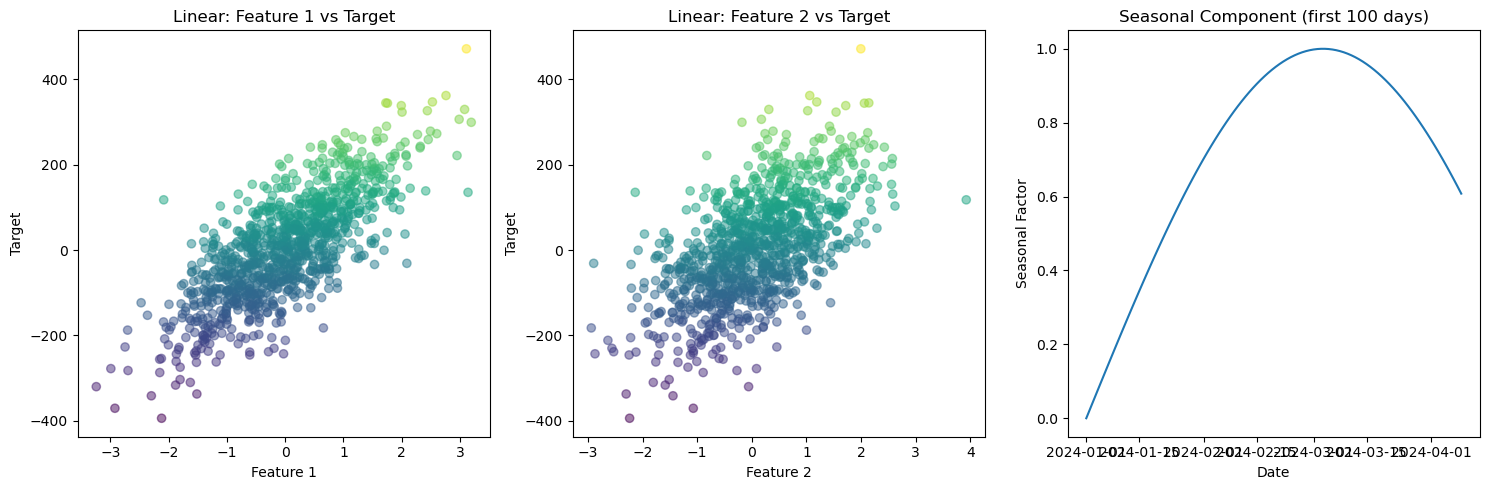

In [6]:
dg = DataGenerator()
dg.generate_regression()
dg.plot()

# Visuals

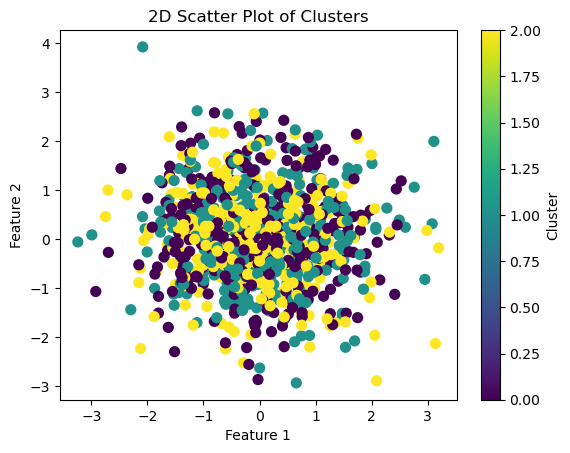

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = dg.data.copy()
df['clus'] = df['category1'].apply(lambda x: 1 if x == 'C' else (0 if x == 'A' else 2))
 
X = df[['feature1','feature2','feature3','target','clus']].values

labels= X[:,4]

# Assuming you have data `X` and cluster labels `labels`
plt.scatter(X[:, 0], X[:, 1], c=X[:,4], cmap='viridis', s=50)
plt.title("2D Scatter Plot of Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster')
plt.show()



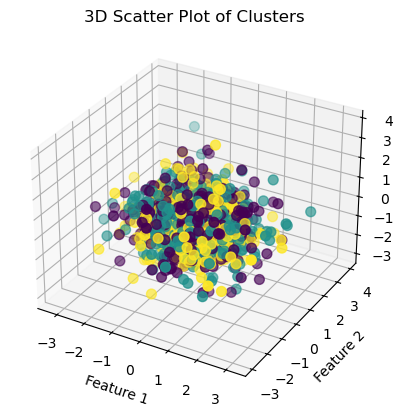

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2],  c=X[:,4], cmap='viridis', s=50)
ax.set_title("3D Scatter Plot of Clusters")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

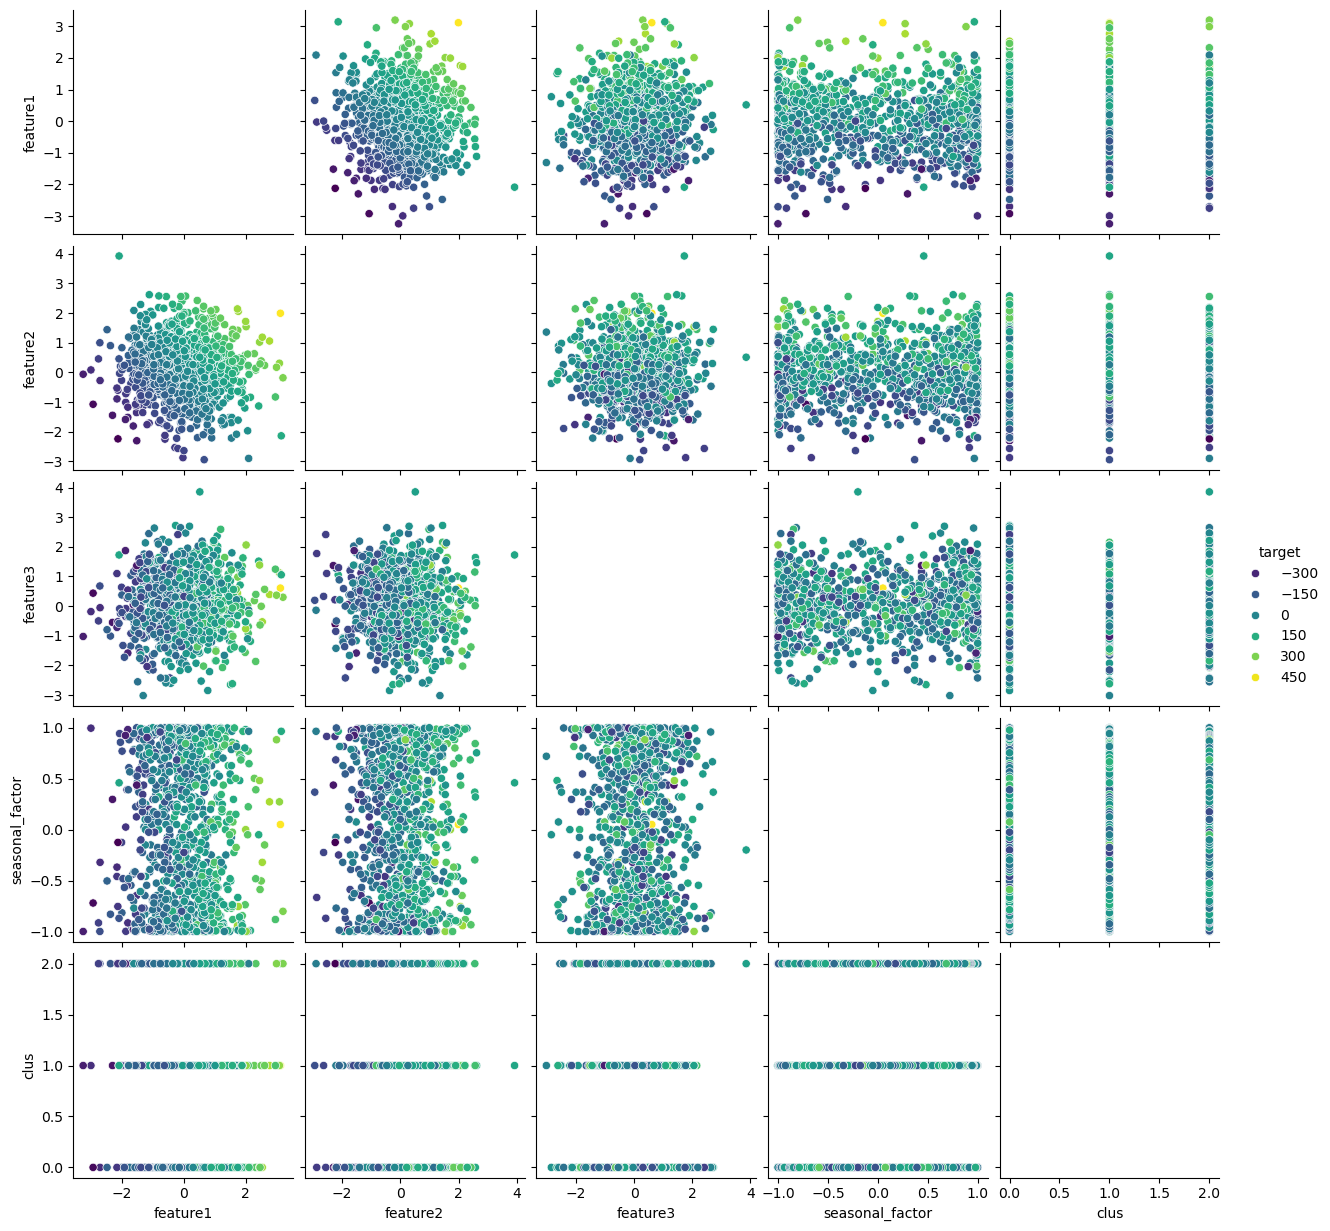

In [9]:
sns.pairplot(df, hue='target', palette='viridis')
plt.show()

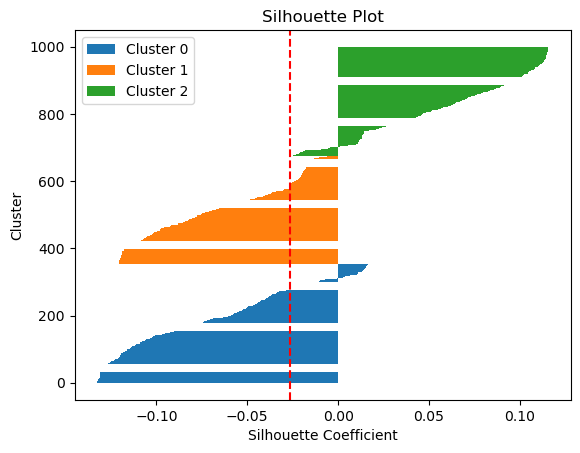

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

silhouette_vals = silhouette_samples(X, X[:,4])
y_ticks = []
y_lower, y_upper = 0, 0

for i in range(len(np.unique(X[:,4]))):
    cluster_silhouette_vals = silhouette_vals[X[:,4] == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', label=f'Cluster {i}')
    y_lower += len(cluster_silhouette_vals)

plt.axvline(x=silhouette_score(X, X[:,4]), color='red', linestyle='--')
plt.title("Silhouette Plot")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.legend()
plt.show()


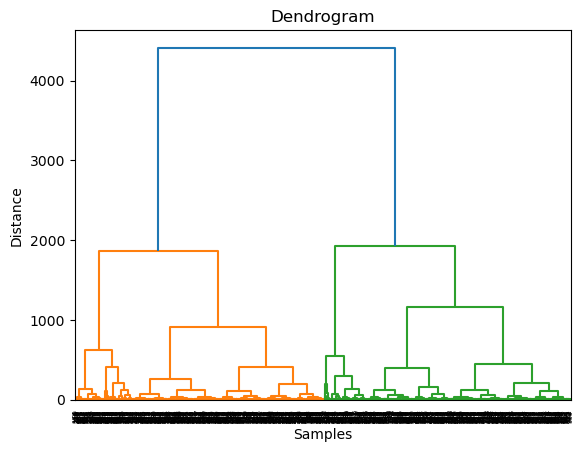

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method='ward')
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

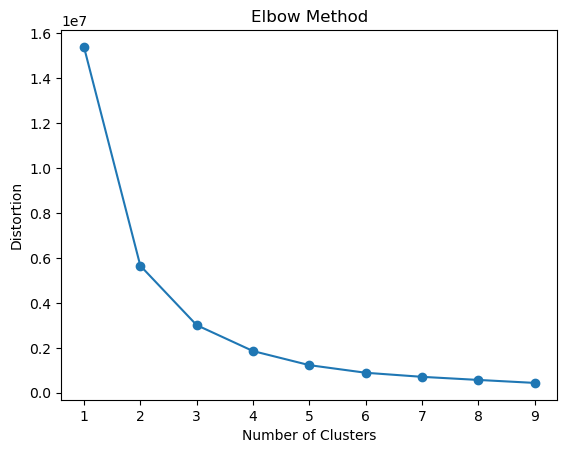

In [12]:
from sklearn.cluster import KMeans
import numpy as np

distortions = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

plt.plot(K, distortions, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()


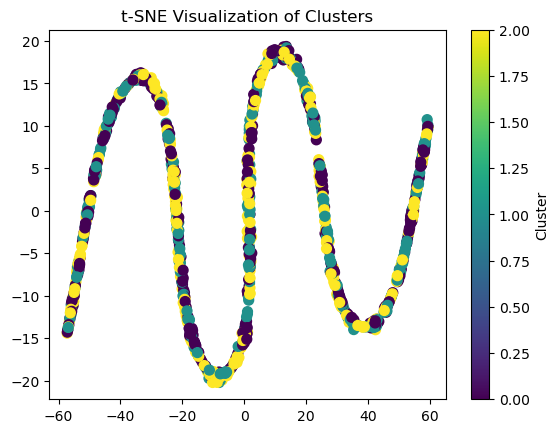

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', s=50)
plt.title("t-SNE Visualization of Clusters")
plt.colorbar(label='Cluster')
plt.show()


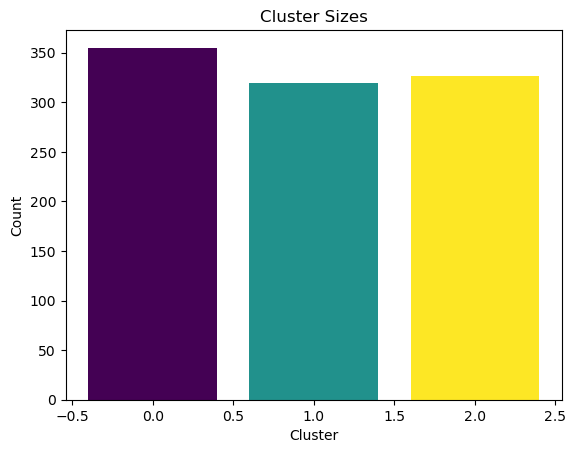

In [14]:
import numpy as np

labels_int = labels.astype(int)
cluster_counts = np.bincount(labels_int)
plt.bar(range(len(cluster_counts)), cluster_counts, color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))))
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()


C:\Users\rober\AppData\Local\Temp\ipykernel_13276\3586337016.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=df['target'], palette='viridis')


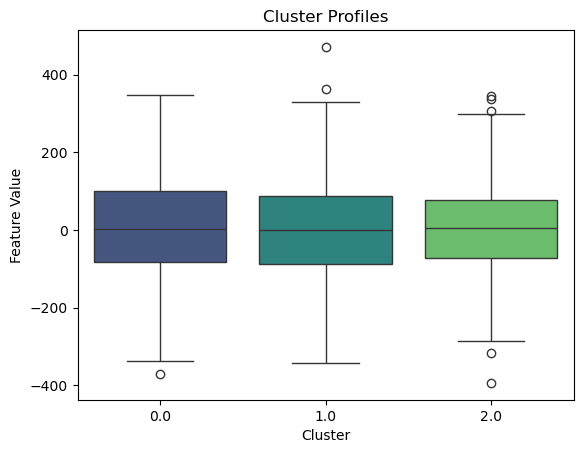

In [15]:
sns.boxplot(x=labels, y=df['target'], palette='viridis')
plt.title("Cluster Profiles")
plt.xlabel("Cluster")
plt.ylabel("Feature Value")
plt.show()


### Cluster Data 

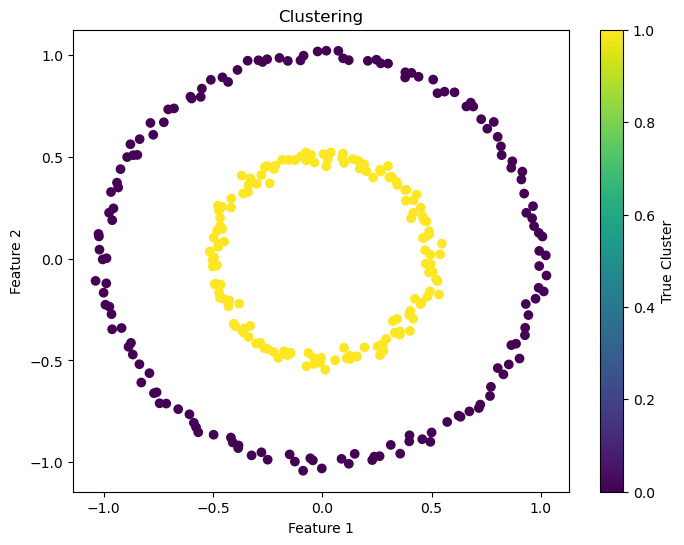

In [16]:
dg = DataGenerator()
dg.generate_cluster('circles', noise=0.02)
dg.plot()

In [17]:
dg.data

,feature1,feature2,true_cluster,feature3,feature4,category
0,-0.278112,0.409024,1,-0.264606,0.900929,C
1,0.127730,-0.492761,1,0.124618,0.869827,A
2,0.470118,0.041148,1,0.465946,1.014099,B
3,0.910516,0.387668,0,0.820281,0.938000,C
4,-0.471349,-0.167179,1,-0.458771,0.985640,C
...,...,...,...,...,...,...
295,0.005863,0.512264,1,-0.007995,0.861437,C
296,-0.960271,0.188013,0,-0.801355,0.976980,C
297,-0.277995,-0.950504,0,-0.268282,0.561698,B
298,0.123977,-0.476686,1,0.139917,0.879634,B


# ML FLOW


In [18]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
 

In [19]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


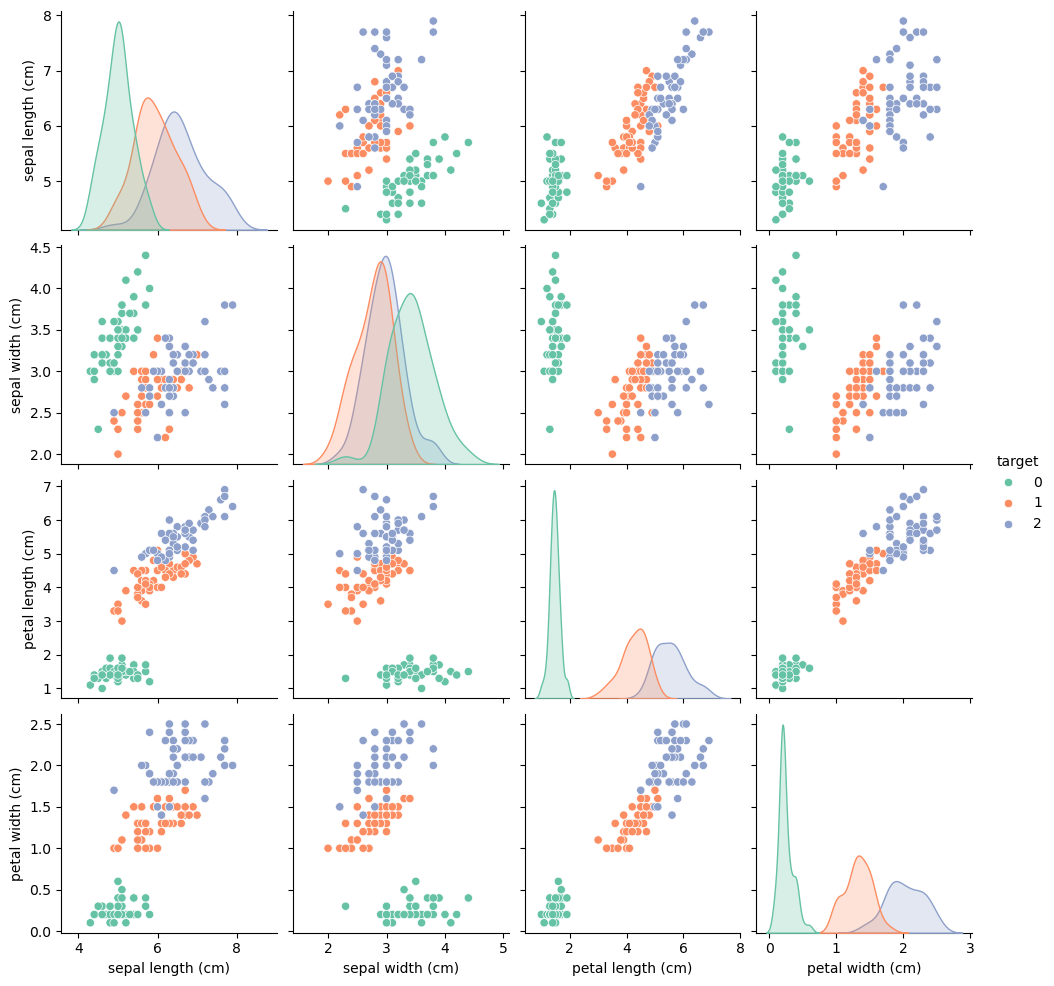

In [20]:
sns.pairplot(df, hue='target', palette='Set2')

# Pipeline Config

In [21]:
#Get columns info
data = dg.data.copy()
col_analizer = ColAnalyzer(data).column_types_
random_state = dg.seed



# Defining column transformations for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), col_analizer['numeric']),
        ('cat', OneHotEncoder(), col_analizer['categorical'])
    ]
)


# Set environment variable to prevent KMeans memory leak on Windows
os.environ['OMP_NUM_THREADS'] = '1'

# Model Pipelines with parameter grids
models = {
    # 'LogisticRegression': {
    #     'model': LogisticRegression(),
    #     'param_grid': {
    #         'model__C': [0.1, 1, 10],
    #         'model__penalty': ['l1', 'l2']
    #     },
    # },
    # 'RandomForest': {
    #     'model': RandomForestClassifier(),
    #     'param_grid': {
    #         'model__n_estimators': [100, 200, 300],
    #         'model__max_depth': [None, 5, 10],
    #         'model__min_samples_split': [2, 5, 10]
    #     },
    # },
    'kmeans': {
        'model': KMeans(random_state=random_state),
        'param_grid': {
            'model__n_clusters': [2, 3, 4]
        },
    },
    'gmm': {
        'model': GaussianMixture(random_state=random_state),
        'param_grid': {
            'model__n_components': [2, 3, 4]
        },
    },
    'dbscan': {
        'model': DBSCAN(),
        'param_grid': {
            'model__eps': [0.3, 0.5, 0.7],
            'model__min_samples': [5, 10]
        },
    },
    'spectral': {
        'model': SpectralClustering(random_state=random_state),
        'param_grid': {
            'model__n_clusters': [2, 3, 4],
            'model__affinity': ['nearest_neighbors', 'rbf']
        },
    }
}



# CV strategies
cv_strategies = {
    'KFold': KFold(n_splits=5, shuffle=True, random_state=42),
    'StratifiedKFold': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    'TimeSeriesSplit': TimeSeriesSplit(n_splits=5)
}


 
# Set scoring
scoring = {
    'calinski_harabasz': make_scorer(ch_scorer),
    'silhouette': make_scorer(silhouette_scorer)
}


# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
 
 


# Pre-process

In [22]:
data = df.copy()
# X, y = data.data, data.target

X, y = data.drop(columns='target', axis=1), data['target']
 

seed = 42
cv = 5


# ColAnalyzer categorizes columns as numeric or categorical
cola = ColAnalyzer(X).column_types_


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Defining column transformations for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cola['numeric']),
        ('cat', OneHotEncoder(), cola['categorical'])
    ]
)


# Training

In [23]:
import time
import mlflow


# Set environment variable for KMeans memory leak
os.environ['OMP_NUM_THREADS'] = '1'

experiment_name = "Clustering Models Grid Search"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except Exception:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
mlflow.set_experiment(experiment_name)

# End any existing runs
mlflow.end_run()


for model_name, mp in models.items():
    try:
        with mlflow.start_run(run_name=f"{model_name}", nested=True) as run:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', mp['model'])
            ])
            
            print(f"\nStarting grid search for {model_name}")
            
            grid_search = GridSearchCV(
                pipeline,
                mp['param_grid'],
                cv=5,
                n_jobs=-1,
                verbose=1,
                scoring=scoring,
                refit=False  # Changed to False since we'll handle best model selection manually
            )
            
            grid_search.fit(X_train)
            
            # Get all results
            results = pd.DataFrame(grid_search.cv_results_)
            
            # Calculate mean scores excluding NaN values
            mean_silhouette = results['mean_test_silhouette'].replace([np.inf, -np.inf], np.nan)
            best_idx = mean_silhouette.idxmax()
            
            # Get best parameters
            best_params = results.loc[best_idx, 'params']
            
            # Fit best model
            best_model = clone(pipeline)
            best_model.set_params(**best_params)
            best_model.fit(X_train)
            
            # Get predictions
            if hasattr(best_model.named_steps['model'], 'labels_'):
                labels = best_model.named_steps['model'].labels_
            else:
                labels = best_model.named_steps['model'].fit_predict(X_train)
            
            # Calculate final scores
            ch_score = calinski_harabasz_score(X_train, labels)
            silhouette_avg = silhouette_score(X_train, labels)
            
            # Log results
            mlflow.log_params(best_params)
            mlflow.log_metric(f'{model_name}_calinski_harabasz', ch_score)
            mlflow.log_metric(f'{model_name}_silhouette', silhouette_avg)
            
            print(f"Completed {model_name}")
            print(f"Best parameters: {best_params}")
            print(f"Silhouette score: {silhouette_avg:.4f}")
            print(f"Calinski-Harabasz score: {ch_score:.4f}")
            
    except Exception as e:
        print(f"Error in {model_name}: {str(e)}")
        continue


Starting grid search for kmeans
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
C:\Users\rober\AppData\Local\Temp\ipykernel_13276\3578218699.py:46: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_idx = mean_silhouette.idxmax()


Error in kmeans: nan

Starting grid search for gmm
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
C:\Users\rober\AppData\Local\Temp\ipykernel_13276\3578218699.py:46: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_idx = mean_silhouette.idxmax()


Error in gmm: nan

Starting grid search for dbscan
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Error in dbscan: Pipeline has none of the following attributes: predict.

Starting grid search for spectral
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Error in spectral: Pipeline has none of the following attributes: predict.


# Algorithms

# 1 Full pipeline

In [27]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


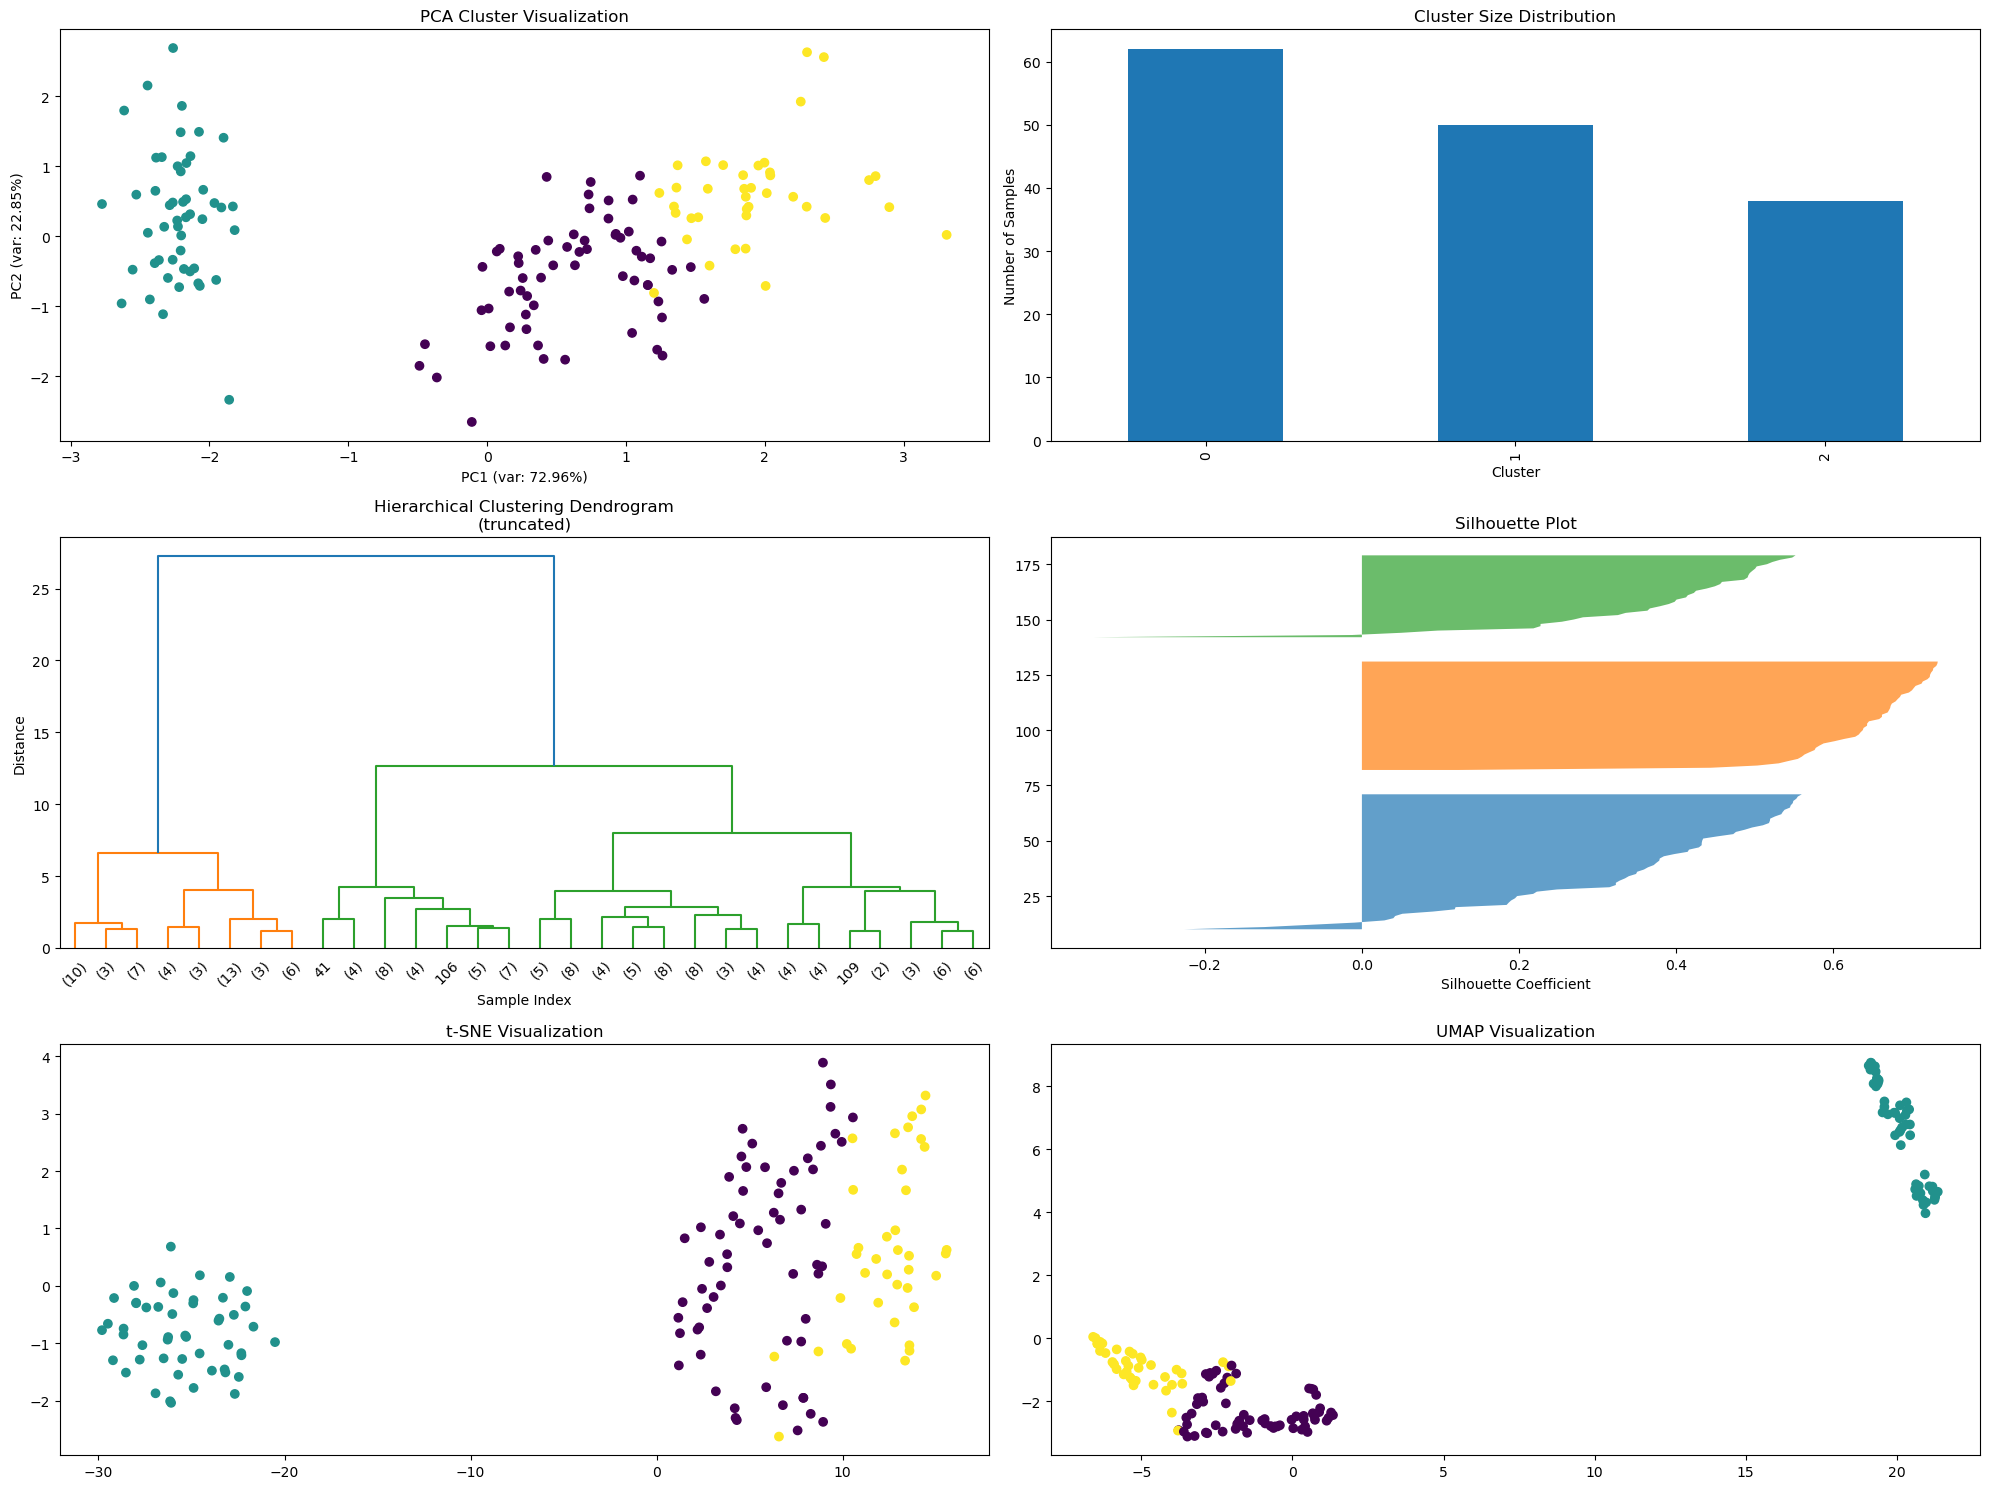

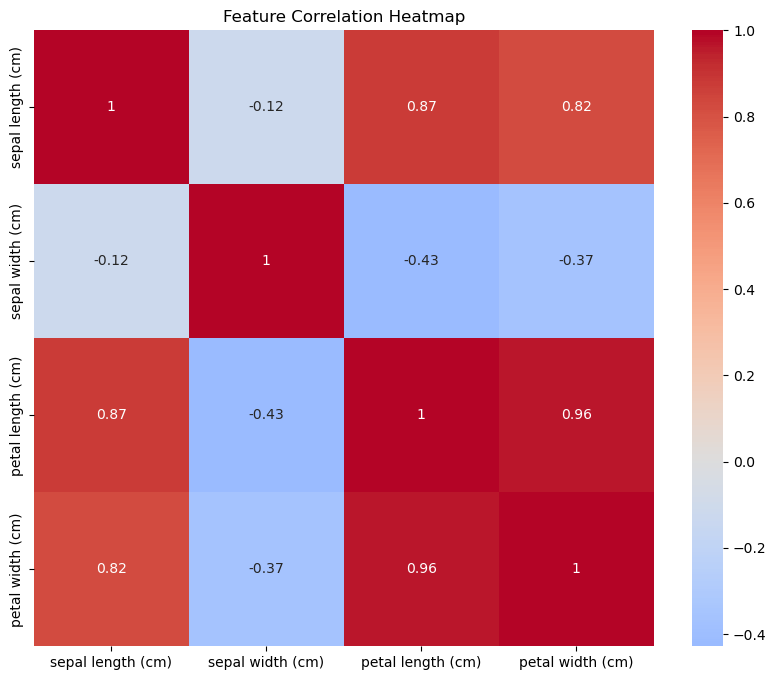

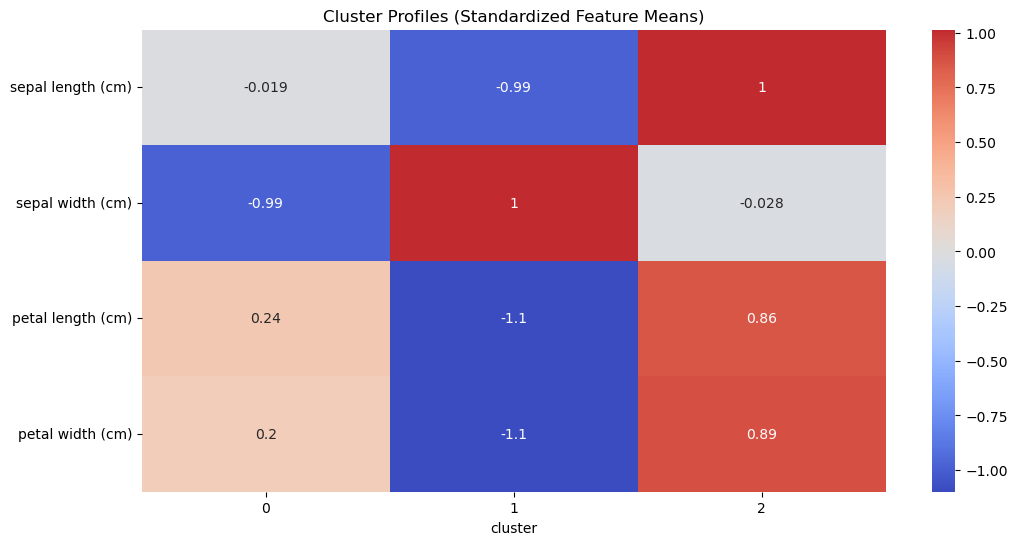

c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


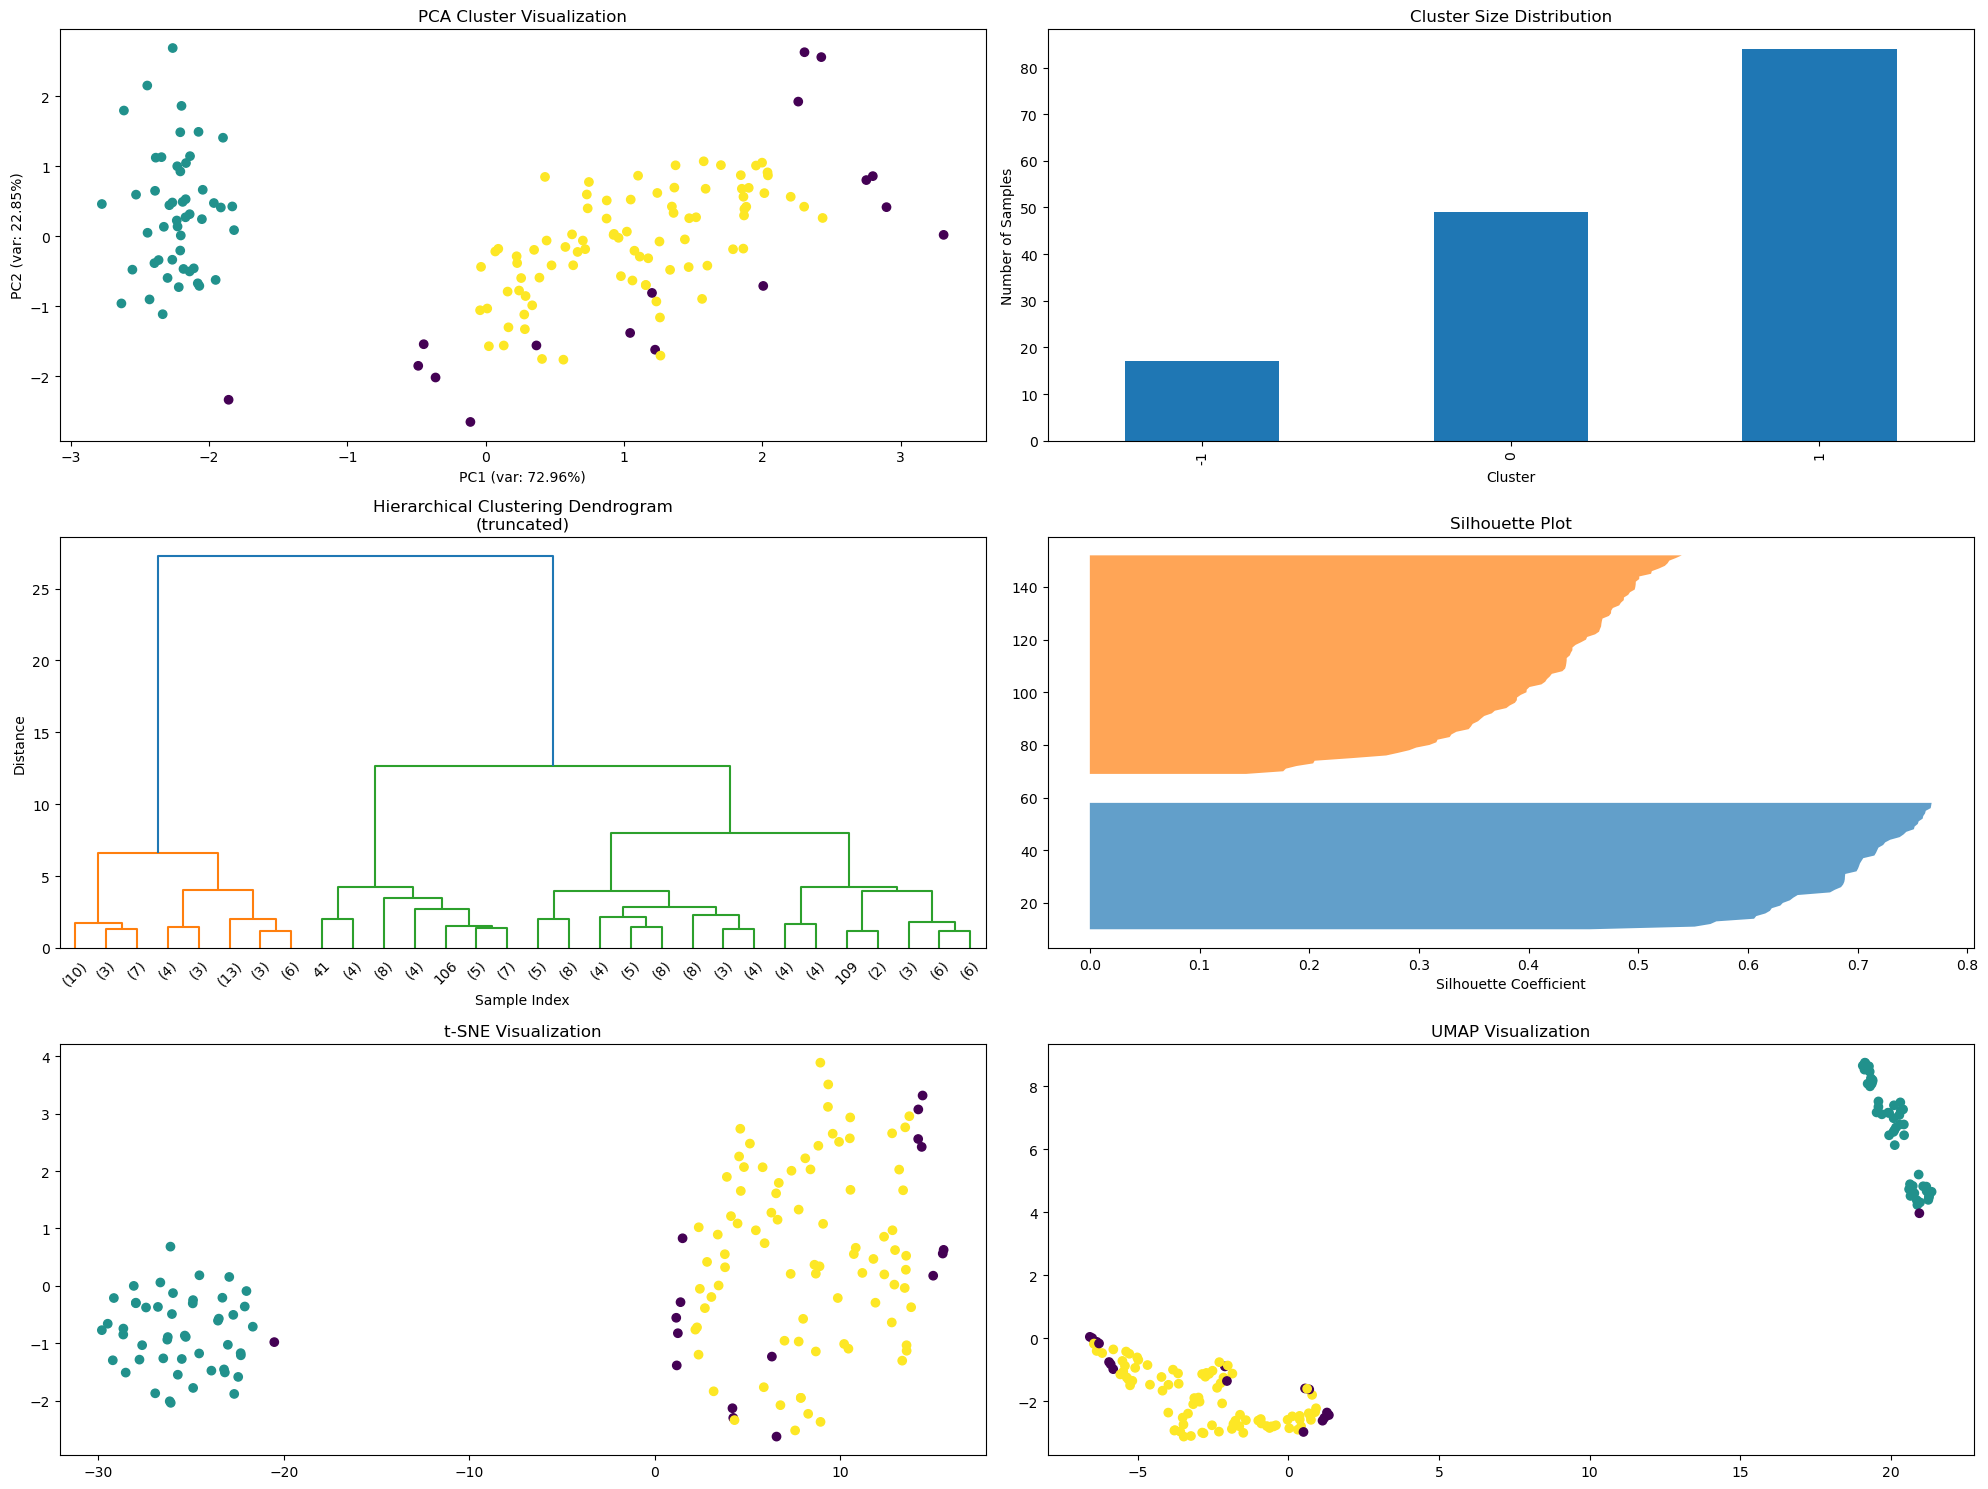

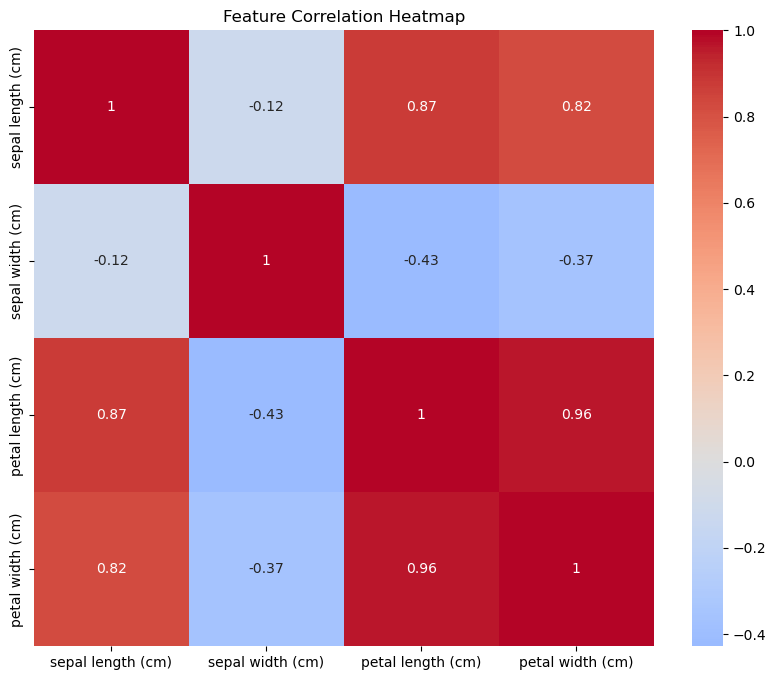

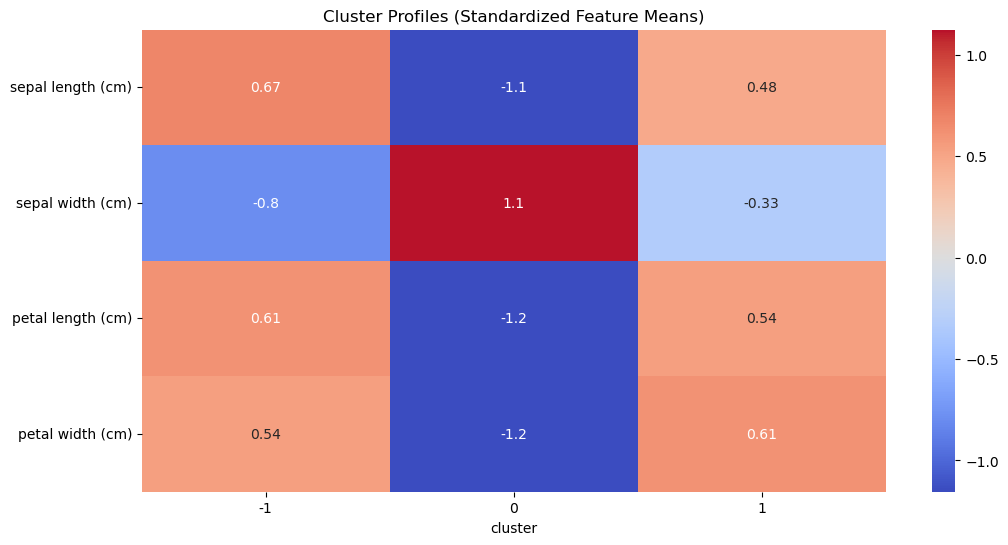

In [28]:
# Example with KMeans
from sklearn.cluster import KMeans

feature_columns = df.drop(columns='target').columns.tolist()

# Assuming your data is in a DataFrame called 'df' with feature columns
kmeans = KMeans(n_clusters=3)
df['cluster'] = kmeans.fit_predict(df[feature_columns])

# Generate all visualizations
plot_clustering_results(df, feature_columns, cluster_column='cluster')

# Example with DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
df['cluster'] = dbscan.fit_predict(df[feature_columns])
plot_clustering_results(df, feature_columns, cluster_column='cluster')

# Using Autoencoders

Epoch 1/50
32/32 [==============================] - 1s 2ms/step - loss: 37.0897
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 36.5435
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 36.1053
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 35.2704
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 34.6841
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 34.5122
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 34.4713
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 34.4570
Epoch 9/50
32/32 [==============================] - 0s 2ms/step - loss: 34.4506
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 34.4471
Epoch 11/50
32/32 [==============================] - 0s 2ms/step - loss: 34.4461
Epoch 12/50
32/32 [==============================] - 0s 2ms/step - loss: 34.4449
Epoch 13/50
32/32 [==================

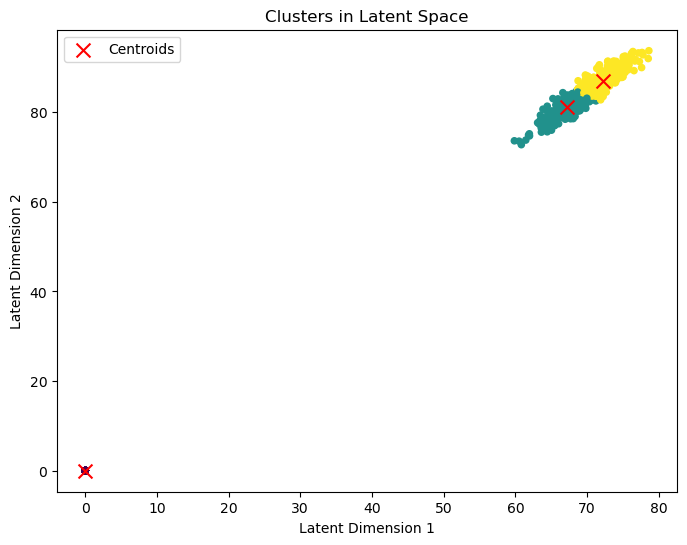

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense

# data Creationg
n_samples = 2000
n_features = 50  # High dimensional
n_clusters = 3
X, y_true = make_blobs(n_samples=n_samples, centers=n_clusters, cluster_std=1.5, n_features=n_features, random_state=42)

# Autoencoder for dimensionality reduction
input_dim = X.shape[1]
latent_dim = 2  # Reduce to 2 dimensions ( for visualization)

# Encoder
encoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(latent_dim, activation='relu')
])

# Decoder
decoder = Sequential([
    Input(shape=(latent_dim,)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

# Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = encoder(input_layer)
decoded = decoder(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=50, batch_size=64, shuffle=True, verbose=1)

# Predict (reduce dimensionality)
X_encoded = encoder.predict(X)

# Use K-Means 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_encoded)

#Evaluate and viz
silhouette_avg = silhouette_score(X_encoded, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")


plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=cluster_labels, cmap='viridis', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title('Clusters in Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()
